In [1]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

import pandas as pd
import numpy as np

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Flatten

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns




In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pd.read_csv("/Users/robbiefeldstein/Documents/Programming/Research/Datasets/May_22.csv")
df.head()


,Unnamed: 0,CMI_C01,CMI_C02,CMI_C03,CMI_C04,CMI_C05,CMI_C06,CMI_C07,CMI_C08,CMI_C09,...,CMI_C14,CMI_C15,CMI_C16,ACM,BCM,Cloud_Probabilities,lat,lon,Coordinates,Lightning
0,0,0.481706,0.431289,0.579424,0.002143,0.478710,0.376825,302.55830,239.46284,247.80550,...,275.37940,274.17140,263.11536,2.156176,0.937424,0.762866,40.131033,-93.381551,"(40.13103323474366, -93.38155072424266)",1
1,1,0.365158,0.305932,0.495337,0.002024,0.376627,0.285793,300.49400,239.29651,247.77374,...,276.07140,274.72607,263.44934,1.843675,0.843675,0.530524,40.126986,-93.274144,"(40.12698592712501, -93.2741436595977)",0
2,2,0.318968,0.255297,0.471785,0.003135,0.333135,0.245873,299.16797,238.83704,247.44296,...,276.19113,274.57343,263.16013,1.874843,0.812655,0.615035,40.122966,-93.166853,"(40.122965705716815, -93.16685328500078)",0
3,3,0.310932,0.245516,0.473551,0.006746,0.323313,0.240774,298.23325,237.81775,246.41095,...,274.68738,272.76428,261.35620,2.905629,1.000000,0.980994,40.118972,-93.059679,"(40.11897247748837, -93.05967862352706)",0
4,4,0.373254,0.310456,0.511190,0.020992,0.365952,0.287559,295.21048,235.05566,243.14026,...,267.70728,265.78076,255.51756,3.000000,1.000000,0.999029,40.115006,-92.952619,"(40.115006150366405, -92.95261870531907)",0


In [4]:
#Look at class imbalance

neg, pos = np.bincount(df['Lightning'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 312500
    Positive: 64000 (20.48% of total)



In [5]:
features = ["CMI_C01", "CMI_C02", "CMI_C03","CMI_C04", "CMI_C05","CMI_C06", "CMI_C07","CMI_C15","Cloud_Probabilities","Lightning"]
#let's just do less features
#Predictors

copy_df = df.copy()
copy_df = copy_df[features]

X = copy_df[features]

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(copy_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Lightning'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Lightning'))
test_labels = np.array(test_df.pop('Lightning'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [6]:
#Averages are roughly similar

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.2043
Average class probability in validation set: 0.2041
Average class probability in test set:       0.2071


In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (200000,)
Validation labels shape: (50000,)
Test labels shape: (62500,)
Training features shape: (200000, 9)
Validation features shape: (50000, 9)
Test features shape: (62500, 9)


In [8]:
#Recommended parameters for imbalanced model

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
    keras.layers.Dense(len(features), activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dropout(0.5),
    #Output layer
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
])

  model.compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.FalsePositives(), tf.keras.metrics.Precision()])

  return model

2023-10-28 15:21:25.821409: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-10-28 15:21:25.821433: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-28 15:21:25.821439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-28 15:21:25.821504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-28 15:21:25.821537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
EPOCHS = 128
BATCH_SIZE = 16384

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [10]:
initial_bias = np.log([pos/len(df)])
print(initial_bias)
model = make_model(output_bias=initial_bias)
model.summary()

[-1.58572139]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                176       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                          

In [11]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [12]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

2023-10-28 15:21:27.075345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Loss: 0.7152


2023-10-28 15:21:29.999355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 496ms/step


array([[0.05333985],
       [0.09517443],
       [0.31102636],
       [0.0891537 ],
       [0.28324202],
       [0.10903572],
       [0.30821165],
       [0.22181803],
       [0.06279704],
       [0.20257062]], dtype=float32)

In [13]:
# model = make_model()
# model.load_weights(initial_weights)
# model.layers[-1].bias.assign([0.0])
# zero_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [14]:
# model = make_model()
# model.load_weights(initial_weights)
# careful_bias_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     epochs=16,
#     validation_data=(val_features, val_labels), 
#     verbose=0)

In [15]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [16]:
# plot_loss(zero_bias_history, "Zero Bias", 0)
# plot_loss(careful_bias_history, "Careful Bias", 1)

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'precision',]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [18]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

4/4 [==============================] - 0s 105ms/step


In [19]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.44


In [24]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
EPOCHS = 150
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=1)

Epoch 1/150


2023-10-28 15:22:13.935629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 2.3399 - false_positives_3: 35156.0000 - precision_3: 0.1972

2023-10-28 15:22:21.658589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 10s 433ms/step - loss: 2.3399 - false_positives_3: 35156.0000 - precision_3: 0.1972 - val_loss: 0.5860 - val_false_positives_3: 1477.0000 - val_precision_3: 0.0160
Epoch 2/150
13/13 [==============================] - 0s 19ms/step - loss: 1.9814 - false_positives_3: 33927.0000 - precision_3: 0.2009 - val_loss: 0.5166 - val_false_positives_3: 1101.0000 - val_precision_3: 0.0134
Epoch 3/150
13/13 [==============================] - 0s 19ms/step - loss: 1.7375 - false_positives_3: 32513.0000 - precision_3: 0.2165 - val_loss: 0.4818 - val_false_positives_3: 509.0000 - val_precision_3: 0.0078
Epoch 4/150
13/13 [==============================] - 0s 17ms/step - loss: 1.6030 - false_positives_3: 32604.0000 - precision_3: 0.2220 - val_loss: 0.4640 - val_false_positives_3: 86.0000 - val_precision_3: 0.4819
Epoch 5/150
13/13 [==============================] - 0s 18ms/step - loss: 1.5037 - false_positives_3: 31713.0000 - precision_3: 0.2321 - val_loss: 0.4596

In [25]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

2023-10-28 15:23:05.392475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


4/4 [==============================] - 1s 278ms/step - loss: 0.5665 - false_positives_3: 9183.0000 - precision_3: 0.4852
loss :  0.5664575099945068
false_positives_3 :  9183.0
precision_3 :  0.48517125844955444

Legitimate Transactions Detected (True Negatives):  40375
Legitimate Transactions Incorrectly Detected (False Positives):  9183
Fraudulent Transactions Missed (False Negatives):  4288
Fraudulent Transactions Detected (True Positives):  8654
Total Fraudulent Transactions:  12942


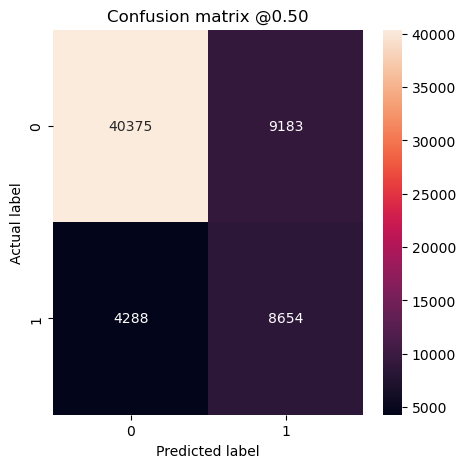

In [26]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=1)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted,threshold=0.5)